# Traitement des données

Imports

In [1]:
import pandas as pd
import numpy as np
from funcs import *
nomenclature = {
    'ER11': 'IG_AAA_Euro_1-3Y',
    'ER12': 'IG_AAA_Euro_3-5Y',
    'ER14': 'IG_AAA_Euro_7-10Y',
    'ER19': 'IG_AAA_Euro_10+Y',
        
    'ER21': 'IG_AA_Euro_1-3Y',
    'ER22': 'IG_AA_Euro_3-5Y',
    'ER24': 'IG_AA_Euro_7-10Y',
    'ER29': 'IG_AA_Euro_10+Y',
    
    'ER31': 'IG_A_Euro_1-3Y',
    'ER32': 'IG_A_Euro_3-5Y',
    'ER34': 'IG_A_Euro_7-10Y',
    'ER39': 'IG_A_Euro_10+Y',
    
    'ER41': 'IG_BBB_Euro_1-3Y',
    'ER42': 'IG_BBB_Euro_3-5Y',
    'ER44': 'IG_BBB_Euro_7-10Y',
    'ER49': 'IG_BBB_Euro_10+Y',
    
}

In [2]:
df = pd.read_csv('ind13_657f441c-1014-4c1c-b235-4dcd7731799a.csv', sep=';')

idx_ig_euro = df.columns.get_loc('ER49')

IG_Euro_df = df.loc[:, :df.columns[idx_ig_euro]]
IG_Euro_df = IG_Euro_df.iloc[1:,:]
index_cols = [col for col in IG_Euro_df.columns if 'Index' in col]
for col in index_cols:
    IG_Euro_df[col] = pd.to_datetime(IG_Euro_df[col], format='%d/%m/%Y', errors='coerce')  # 'coerce' will turn invalid parsing into NaT


## Synchronisation des Données Temporelles

### Problème

Les ensembles de données des deux marchés présentent des chronologies décalées, nécessitant un alignement pour des analyses précises.

### Solution

Nous avons utilisé la fonction `aligns_dfs` pour synchroniser les séries temporelles des dataframes. La fonction procède comme suit :

- **Identification des Dates** : Sélection du sous-ensemble de dates minimisant les valeurs manquantes (NaN).
- **Construction du Dataframe** : Création d'un nouveau dataframe avec dates alignées. En cas de dates non concordantes, utilisation de la dernière valeur disponible.
- **Gestion des NaN** : Conversion des valeurs en numérique et application d'un forward fill pour les NaN résiduels.

### Résultat

Le dataframe résultant offre des séries temporelles synchronisées, permettant des comparaisons précises entre les marchés.

In [3]:
df_aligned = aligns_dfs(IG_Euro_df)
df_spread_diff = df_aligned.diff().dropna()

# On notations

## Création d'Indices par Notation

### Objectif

Créer des indices spécifiques par bucket de maturité pour analyser les courbes de spread par notation.

### Méthodologie

Les indices sont constitués en équi-pondérant les différentes maturités au sein de chaque bucket. Cette approche assure une répartition uniforme de l'influence de chaque maturité sur l'indice global.


In [4]:
DICT_NOTATIONS_TO_ISIN = {
    'AAA' : ['ER11', 'ER12', 'ER14', 'ER19'],
    'AA' :  ['ER21', 'ER22', 'ER24', 'ER29'],
    'A' :  ['ER31', 'ER32', 'ER34', 'ER39'],
    'BBB' :  ['ER41', 'ER42', 'ER44', 'ER49']
}


In [5]:
df_spread_diff_notation = pd.DataFrame(index=df_spread_diff.index)

for notation, isin_list in DICT_NOTATIONS_TO_ISIN.items():
    existing_isins = [isin for isin in isin_list if isin in df_spread_diff.columns]
    
    if existing_isins:  
        df_spread_diff_notation[notation] = df_spread_diff[existing_isins].mean(axis=1)


## Analyse en Composantes Principales (ACP) des Spreads de Crédit

### Prétraitement des Données

1. **Nettoyage des données** : Suppression des valeurs manquantes dans le dataframe `df_spread_diff_notation` pour garantir l'intégrité des données pour l'analyse.

### Standardisation des Données

2. **Standardisation** : Application d'une transformation standard (moyenne = 0, écart-type = 1) à l'ensemble des données. Cette étape est cruciale pour que l'ACP ne soit pas biaisée par les échelles variables des caractéristiques originales.

### Application de l'ACP

3. **Initialisation et ajustement de l'ACP** : Création d'un objet PCA, ajustement aux données standardisées pour identifier les axes principaux de variation.

4. **Transformation des données** : Application de la transformation PCA aux données standardisées pour réduire la dimensionnalité tout en capturant le maximum de variance.

### Résultats de l'ACP

5. **DataFrame des Composantes Principales** : Création d'un nouveau dataframe `df_pca` avec les composantes principales comme nouvelles caractéristiques. Les colonnes sont nommées `PC1`, `PC2`, etc., selon leur ordre de variance expliquée.

6. **Matrice de Chargement** : Création d'un dataframe `df_loadings` contenant les vecteurs propres (composantes de l'ACP). Chaque colonne représente une composante principale et chaque ligne correspond à une variable originale, indiquant l'importance (ou la contribution) de chaque variable à la composante principale.

### Variance Expliquée

7. **Impression de la Variance Expliquée** : Affichage de la part de variance expliquée par chaque composante principale, permettant d'évaluer l'importance relative de chaque composante dans la description de la dynamique des données.

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df_spread_diff_notation = df_spread_diff_notation.dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_spread_diff_notation)

pca = PCA()
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)


df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])], index=df_spread_diff_notation.index)
df_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])], index=df_spread_diff_notation.columns)

explained_variance_ratio = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {variance:.2%}")


PC1: 76.14%
PC2: 13.11%
PC3: 8.49%
PC4: 2.26%


## Résultats de Variance Expliquée par les Composantes Principales

Les pourcentages de variance expliquée par les quatre premières composantes principales sont les suivants :

- **PC1**: 76.14%
- **PC2**: 13.11%
- **PC3**: 8.49%
- **PC4**: 2.26%

### Décision sur le Nombre de Composantes à Retenir

Étant donné que la première composante principale (PC1) explique une part substantielle de la variance (76.14%), et que les trois premières composantes cumulent ensemble 97.74% de la variance totale, nous choisissons de retenir ces trois composantes pour les analyses subséquentes. Cette décision nous permet de capturer la majorité des dynamiques de marché tout en réduisant la dimensionnalité des données.

In [7]:
# df_loadings 

## Analyse des Vecteurs Propres pour les Composantes Principales

### Données des Composantes Principales

| Rating | PC1      | PC2      | PC3      | PC4      |
|--------|----------|----------|----------|----------|
| AAA    | 0.441378 | -0.849827| 0.286974 | 0.025003 |
| AA     | 0.522627 | 0.039121 | -0.638908| -0.563141|
| A      | 0.543866 | 0.229484 | -0.224465| 0.775347 |
| BBB    | 0.486061 | 0.472865 | 0.677538 | -0.284755|55



### Interprétation des Composantes

- **PC1 (Translation)**: Cette composante indique une augmentation uniforme de la courbe des spreads lorsque \(\Delta Spread\) est positif, reflétant une translation globale de la courbe.
- **PC2 (Rotation ou Carry de Notation)**: Cette compoindique que beaucoup ont vendu des produits très bien notés, en qui ils n'avaient plus confiance, et certains investisseurs opportunistes ont peut-être commencé à acheter des actifs mal notés (et donc fortement décotés), pariant sur une reprise.ation.
- **PC3 (Butterfly ou Torsion)**: Cette composante montre un ajustement plus complexe, souvent décrit comme un butterfly ou une torsion, affectant différemment les maturités ou les notations au sein de la courbe des spreads.


## Régression des Composantes Principales sur les Marchés

### Méthodologie de Régression

Nous employons une régression de type Ridge pondérée exponentiellement avec une fenêtre glissante de 52 semaines et une demi-vie de 4 semaines. Cette approche est choisie pour deux raisons principales :

1. **Pondération des Événements Récents** : Le modèle attribue plus de poids aux données les plus récentes. Cela est essentiel pour capturer les réactions immédiates du marché face à des événements financiers récents, augmentant ainsi la capacité du modèle à identifier et réagir aux crises.

2. **Coefficients Explicatifs Continus** : La régression fournit des coefficients explicatifs pour chaque composante principale tout au long de la période analysée. Cela permet d'observer l'évolution de l'influence de chaque composante principale sur les marchés au fil du temps.

### Objectifs du Modèle

- **Adaptabilité** : En ajustant continuellement les poids, le modèle reste sensible aux changements du marché, offrant une analyse dynamique et actuelle.
- **Interprétation des Facteurs** : Chaque composante principale est analysée séparément pour comprendre son impact spécifique sur les variations des marchés de crédit.


In [8]:
window_size = 52
alpha = 1

EU_NOTATION_PC_REG  = make_ridge_on_pca_factors(df_spread_diff_notation, df_pca[['PC1', 'PC2', 'PC3']],alpha, window_size, halflife=4)


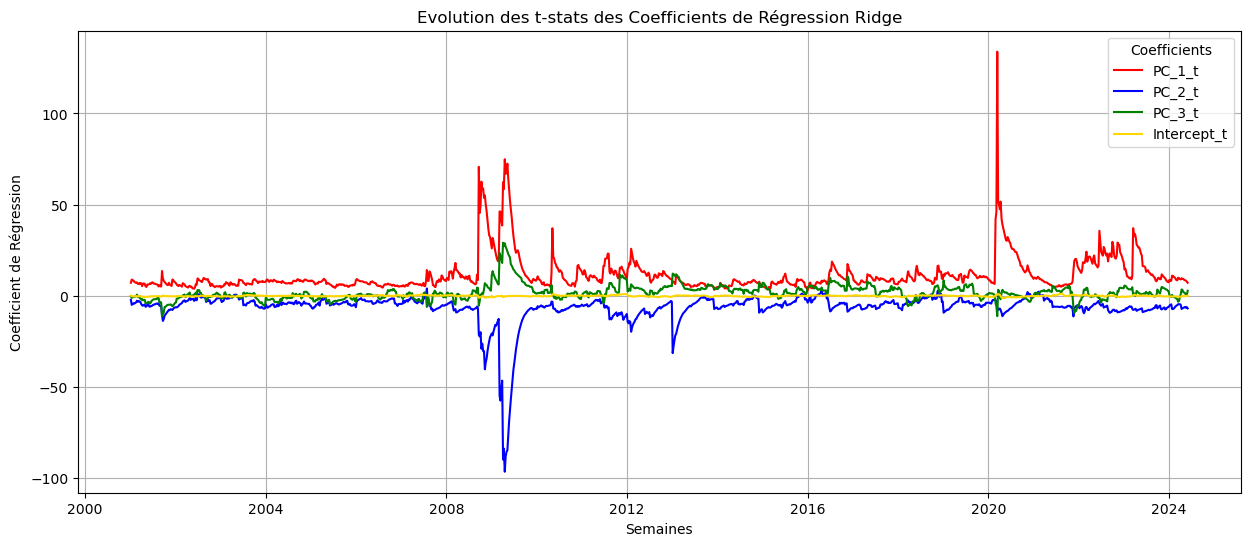

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


col_coef = ['PC_1_t', 'PC_2_t', 'PC_3_t', 'Intercept_t']

colors = {
    'PC_1_t': 'red', 
    'PC_2_t': 'blue', 
    'PC_3_t': 'green', 
    'Intercept_t': 'gold' 
}

plt.figure(figsize=(15, 6))

for column, color in colors.items():
    plt.plot(EU_NOTATION_PC_REG['AAA'][[column]], color=color, label=column)


plt.title('Evolution des t-stats des Coefficients de Régression Ridge')
plt.xlabel('Semaines')
plt.ylabel('Coefficient de Régression')
plt.grid(True)
plt.legend(title='Coefficients')
plt.show()

## Analyse des t-statistiques des Coefficients de Régression Ridge sur les Marchés Européens par Notation

Le graphique suivant illustre les variations des t-statistiques des coefficients de régression Ridge pour les composantes principales (PC1, PC2, PC3) et l'intercept sur les marchés européens par notation. Les mouvements significatifs dans les graphiques sont analysés en fonction de trois crises majeures.

### Analyse des Événements Marquants

#### Crise des Subprimes (2008)
- **PC1**: Une forte hausse des t-statistiques indique une explosion des spreads de crédit, ce qui reflète une anticipation des marchés de hauts niveaux de défauts.
- **PC2**: Augmentation qui suggère que les investisseurs shortent le carry, favorisant les titres mieux notés par rapport aux moins bien notés.
- **Réaction des Politiques Monétaires**: L'intervention des banques centrales, notamment la BCE et la Fed, avec des programmes de quantitative easing, a aidé à stabiliser les marchés.

#### Crise de la Dette Européenne (2011-2012)
- **PC1**: Légère augmentation, signe que les spreads de crédit étaient en hausse due à l'instabilité financière et aux craintes de défaut souverain dans la zone euro.
- **PC2**: Activité modérée, indiquant la peur des investisseurs pour le futur et des ajustements dans les stratégies de carry des portefeuilles.
- **Réaction des Politiques Monétaires**: Les mesures de la BCE, incluant l'OMT, ont contribué à calmer les marchés et à restaurer la confiance des investisseurs.

#### Pandémie de COVID-19 (2020)
- **PC1**: Un pic extrême indique une réaction vive des marchés aux craintes de défauts massifs causés par les arrêts économiques et la récession.
- **PC2**: Peu de changements significatifs, suggérant que les ajustements en termes de carry n'étaient pas la préoccupation principale durant cette crise, sûrement car les marchés priçaient des défauts pour toutes les tranches de notation.
- **Réaction des Politiques Monétaires**: Les réponses rapides, y compris le soutien financier massif et les baisses des taux d'intérêt par les banques centrales, ont aidé à stabiliser les marchés rapidement.

#### Crise Bancaire aux États-Unis et Impact sur les Marchés Européens (2023)
- **PC1**: La crise a influencé les dynamiques de marché en Europe, avec des augmentations des spreads de crédit reflétant l'incertitude internationale et la peur des défauts de plusieurs banques.
- **Réponse des Politiques Monétaires**: Les actions coordonnées des banques centrales, incluant la BCE et la Fed, ont été cruciales pour limiter l'impact de la crise bancaire américaine sur les marchés européens.



# On Maturities

In [10]:
DICT_MATURITIES_TO_ISIN = {
    '1-3Y' : ['ER11', 'ER21', 'ER31', 'ER41'],
    '3-5Y' :  ['ER12', 'ER22', 'ER32', 'ER42'],
    '7-10Y' :  ['ER14', 'ER24', 'ER34', 'ER44'],
    '10+' :  ['ER19', 'ER29', 'ER39', 'ER49']
}


df_spread_diff = df_aligned.diff().dropna()
df_spread_diff_maturities = pd.DataFrame(index=df_spread_diff.index)

for maturity, isin_list in DICT_MATURITIES_TO_ISIN.items():
    existing_isins = [isin for isin in isin_list if isin in df_spread_diff.columns]
    if existing_isins:
        df_spread_diff_maturities[maturity] = df_spread_diff[existing_isins].mean(axis=1)
df_spread_diff_maturities = df_spread_diff_maturities.dropna()


In [11]:

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_spread_diff_maturities)

pca = PCA()
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)


df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])], index=df_spread_diff_maturities.index)
df_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])], index=df_spread_diff_maturities.columns)
explained_variance_ratio = pca.explained_variance_ratio_
# for i, variance in enumerate(explained_variance_ratio):
#     print(f"PC{i+1}: {variance:.2%}")

### Variance Expliquée

**Ratios de Variance Expliquée** : 
   - **PC1**: 86.93% - Indique que la première composante principale capte une grande majorité de la variance dans les données.
   - **PC2**: 8.34%
   - **PC3**: 3.04%
   - **PC4**: 1.68%

### Conclusion

Les résultats de l'ACP montrent que la majorité de la variance (86.93%) peut être attribuée à la première composante principale, soulignant une influence dominante de cette composante sur les variations des spreads de crédit. Les trois premières composantes ensemble expliquent près de 98.31% de la variance totale, ce qui suggère que ces dimensions capturent efficacement les dynamiques principales des spreads de crédit par maturité.

In [12]:
# df_loadings

## Interprétation des Charges des Composantes Principales

Le tableau suivant montre les charges (loadings) des différentes maturités sur les quatre premières composantes principales calculées à partir de l'Analyse en Composantes Principales des spreads de crédit par maturité.

### Tableau des Charges

| Maturité | PC1      | PC2      | PC3      | PC4      |
|----------|----------|----------|----------|----------|
| 1-3Y     | 0.441378 | -0.849827| 0.286974 | 0.025003 |
| 3-5Y     | 0.522627 | 0.039121 | -0.638908| -0.563141|
| 7-10Y    | 0.543866 | 0.229484 | -0.224465| 0.775347 |
| 10+      | 0.486061 | 0.472865 | 0.677538 | -0.284755|

### Interprétation des Composantes Principales

- **PC1 (Translation)**: Toutes les maturités ont des charges positives significatives, indiquant que PC1 représente une translation générale de la courbe des spreads. Une hausse de PC1 indique une augmentation uniforme des spreads sur toutes les maturités.
- **PC2 (Rotation ou Carry sur la Courbe de Maturité)**: Cette composante montre une dynamique de carry, où les poids positifs sur les longues maturités (notamment 10+ ans) et les poids négatifs sur les plus courtes (1-3 ans) suggèrent une stratégie de vendre du court terme pour acheter du long terme.
- **PC3 (Torsion ou Butterfly)**: Indiquent un ajustement de type butterfly ou torsion dans la structure de la courbe des spreads.


In [13]:
window_size = 52
alpha = 1

EU_MATURITIES_PC_REG  = make_ridge_on_pca_factors(df_spread_diff_maturities, df_pca[['PC1', 'PC2', 'PC3']],alpha, window_size, halflife=4)


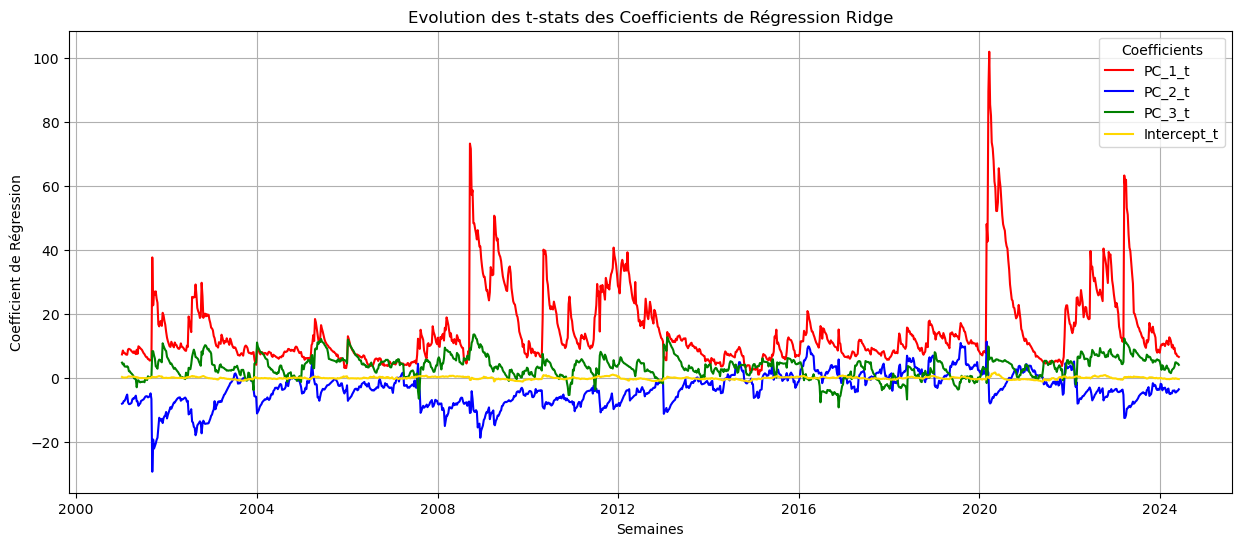

In [14]:
col_coef = ['PC_1_t', 'PC_2_t', 'PC_3_t', 'Intercept_t']

colors = {
    'PC_1_t': 'red', 
    'PC_2_t': 'blue', 
    'PC_3_t': 'green', 
    'Intercept_t': 'gold' 
}

plt.figure(figsize=(15, 6))

for column, color in colors.items():
    plt.plot(EU_MATURITIES_PC_REG['1-3Y'][[column]], color=color, label=column)


plt.title('Evolution des t-stats des Coefficients de Régression Ridge')
plt.xlabel('Semaines')
plt.ylabel('Coefficient de Régression')
plt.grid(True)
plt.legend(title='Coefficients')
plt.show()

## Analyse des t-statistiques des Coefficients de Régression Ridge pour les Maturités des Actifs

Ce graphique illustre l'évolution des t-statistiques pour les composantes principales des maturités des actifs de 2000 à 2024, en se concentrant sur les réactions du marché lors de crises financières majeures et en observant les différences de réactions par rapport aux notations.

### Analyse des Événements Marquants

#### Crise des Subprimes (2008)
- **PC1**: Une forte hausse de PC1 montre une augmentation significative des spreads de crédit à travers toutes les maturités, indiquant une réaction globale du marché à l'augmentation du risque de défaut.
- **PC2**: Pas de hausse significative, suggérant que notre modèle n'a pas capturé d'effet significatif sur les ajustements de carry durant cette crise.

#### Crise de la Dette Européenne (2011-2012)
- **PC1**: Augmentation modérée, reflétant l'inquiétude sur les défauts souverains dans la zone euro.
- **PC2**: Activité faible, confirmant l'absence de réactions significatives aux stratégies de carry, avec une hausse notable du short de carry seulement en 2013.

#### Pandémie de COVID-19 (2020)
- **PC1**: Un pic prononcé indique des spreads de crédit rapidement élargis en réponse à l'incertitude économique mondiale.
- **PC2**: Peu de changement, suggérant que les ajustements de carry n'étaient pas une préoccupation majeure des investisseurs durant cette crise.
- **Réaction des Politiques Monétaires**: Les interventions rapides et le soutien financier massif des banques centrales ont stabilisé les marchés efficacement.

#### Crise Bancaire aux États-Unis et Impact sur les Marchés Européens (2023)
- **PC1**: La crise a influencé les dynamiques de marché en Europe, avec des augmentations des spreads de crédit reflétant l'incertitude internationale.
- **Réponse des Politiques Monétaires**: Les actions coordonnées des banques centrales, incluant la BCE et la Fed, ont été cruciales pour limiter l'impact de la crise bancaire américaine sur les marchés européens.


### Remarque sur les Différences entre Maturités et Notations
Il est notable que les t-statistiques pour les maturités ne capturent pas toujours les mêmes réactions que celles observées pour les notations. Les notations tendent à réfléchir des ajustements plus spécifiques basés sur la qualité perçue du crédit, tandis que les maturités montrent des réactions aux conditions de marché générales. Cette distinction est cruciale pour comprendre comment les marchés ajustent leurs perceptions du risque en réponse à différentes crises, illustrant la complexité des dynamiques de marché sous-jacentes.



# Conclusion

Notre étude démontre que les facteurs obtenus par l'Analyse en Composantes Principales (PCA) possèdent non seulement une signification statistique robuste mais aussi une forte pertinence financière à travers le temps. Les résultats montrent une dynamique consistante entre les notations et les maturités des actifs, ce qui est rassurant. Cela suggère que, malgré leurs différences apparentes, ces dimensions reflètent fidèlement les niveaux de risque inhérents aux actifs sous-jacents. Cette cohérence entre les différentes catégories d'actifs illustre bien comment les risques sont perçus et gérés sur les marchés financiers.
